In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

C:\Users\Vladimir Kimbris\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Vladimir Kimbris\AppData\Local\Programs\Python\Python310\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Ссылка на датасет https://www.kaggle.com/datasets/moazeldsokyx/dogs-vs-cats
#Использую test и validation вборки, потому что train очень большая и не помещается в оперативную память

In [5]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/DogsCats/dataset/test"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_path = "C:/Users/das-s/Downloads/DogsCats/dataset/validation"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Feature batch shape: torch.Size([30, 3, 256, 256])
Labels batch shape: torch.Size([30])


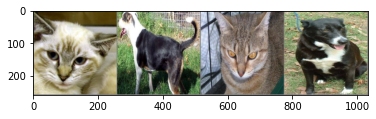

cats	 dogs	 cats	 dogs	


In [13]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [14]:
# Функция формирования набора данных (картинки и метки)
def extract_dataset_images(dataloader):
  labels = []
  images = []
  for batch, batch_labels in tqdm(dataloader):
    images.append(batch.detach().numpy().reshape((batch.shape[0], -1))) # Делаем картинки в виде векторов
    labels.append(batch_labels.detach().numpy())
  return np.concatenate(images), np.concatenate(labels)

In [15]:
x_train, y_train = extract_dataset_images(train_dataloader)
x_test, y_test = extract_dataset_images(test_dataloader)

100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


# KNN

In [16]:
def train_and_test_KNN(x_train, y_train, x_test, y_test, n_neighbors, metric, weights):
  # Обучение KNN на картинках
  knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric = metric, weights = weights)
  knn_classifier.fit(x_train, y_train)

  # Тестирование
  # Классификация тестовых изображений с использованием KNN
  y_pred = knn_classifier.predict(x_test)

  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [17]:
def inverse_squared_distance(dist):
    arr = []
    for d in dist:
        arr.append(1 / (d**2))
    return arr

In [18]:
metrics_array = ["minkowski", "euclidean", "cosine"]
weights_array = ["uniform", "distance", inverse_squared_distance]
n_neighbors = [3, 5, 10, 20, 30]

In [20]:
best_accuracy = 0
best_n_neighbors = 0
best_metric = ""
best_weights = ""
for metric in metrics_array:
    for weights in weights_array:
        for n in n_neighbors:
            accuracy = train_and_test_KNN(x_train, y_train, x_test, y_test, n, metric, weights)
            print(f"n = {n}, metric = {metric}, weights = {weights} \naccuracy = {accuracy:.3f}\n")
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_n_neighbors = n
                best_metric = metric
                best_weights = weights
print('-'*50)
print("Best KNN accuracy:")
print(f"n_neighbors = {best_n_neighbors} \nmetric = {best_metric} \nweights = {best_weights} \naccuracy = {best_accuracy}")

  0%|          | 0/2 [00:00<?, ?it/s]

n = 3, metric = minkowski, weights = uniform 
accuracy = 0.550
n = 5, metric = minkowski, weights = uniform 
accuracy = 0.500
n = 10, metric = minkowski, weights = uniform 
accuracy = 0.600
n = 3, metric = minkowski, weights = distance 
accuracy = 0.550
n = 5, metric = minkowski, weights = distance 
accuracy = 0.500


 50%|█████     | 1/2 [00:06<00:06,  6.23s/it]

n = 10, metric = minkowski, weights = distance 
accuracy = 0.500
n = 3, metric = euclidean, weights = uniform 
accuracy = 0.550
n = 5, metric = euclidean, weights = uniform 
accuracy = 0.500
n = 10, metric = euclidean, weights = uniform 
accuracy = 0.600
n = 3, metric = euclidean, weights = distance 
accuracy = 0.550
n = 5, metric = euclidean, weights = distance 
accuracy = 0.500


100%|██████████| 2/2 [00:12<00:00,  6.11s/it]

n = 10, metric = euclidean, weights = distance 
accuracy = 0.500

--------------------------------------------------
Best KNN accuracy:
n_neighbors = 10 
metric = minkowski 
weights = uniform 
accuracy = 0.6


In [21]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric, weights=best_weights)
knn_classifier.fit(x_train, y_train)
y_pred = knn_classifier.predict(x_test)
print(classification_report(y_test, y_pred, target_names=test_ds.classes))

              precision    recall  f1-score   support

        cats       0.56      1.00      0.71        10
        dogs       1.00      0.20      0.33        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20


# PCA+KNN

In [22]:
def train_and_test_PCA_KNN(x_train, y_train, x_test, y_test, n_components, knn_classifier):
  pca = PCA(n_components=n_components)
  x_train_pca = pca.fit_transform(x_train)
  knn_classifier.fit(x_train_pca, y_train)

  # Тестирование
  # Применение созданного ранее PCA для тестовых данных
  x_test_pca = pca.transform(x_test)
  # Классификация тестовых изображений с использованием KNN
  y_pred = knn_classifier.predict(x_test_pca)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

In [28]:
n_components = [10, 50, 100, 200, 300, 500, 700]

In [30]:
best_accuracy = 0
best_n_neighbors = 0
best_metric = ""
best_weights = ""
best_n_components = 0

for metric in metrics_array:
    for weights in weights_array:
        for n_n in n_neighbors:
            for n_c in n_components:
                knn_classifier = KNeighborsClassifier(n_neighbors=n_n, metric = metric, weights = weights)
                accuracy = train_and_test_PCA_KNN(x_train, y_train, x_test, y_test, n_c, knn_classifier)
                print(f"n_neighbors = {n_n}, metric = {metric}, weights = {weights}, n_components = {n_c}")
                print(f"accuracy = {accuracy:.3f}\n")
                print('-'*50)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_n_neighbors = n_n
                    best_metric = metric
                    best_weights = weights
                    best_n_components = n_c
print('-'*50)
print("Best PCA+KNN accuracy:")
print(f"n_neighbors = {best_n_neighbors} \nmetric = {best_metric} \nweights = {best_weights}")
print(f"n_components = {best_n_components} \naccuracy = {best_accuracy:.3f}")

  0%|          | 0/2 [00:00<?, ?it/s]

n_neighbors = 3, metric = minkowski, weights = uniform, n_components = 10
accuracy = 0.450

--------------------------------------------------
n_neighbors = 3, metric = minkowski, weights = uniform, n_components = 15
accuracy = 0.550

--------------------------------------------------
n_neighbors = 3, metric = minkowski, weights = uniform, n_components = 20
accuracy = 0.550

--------------------------------------------------
n_neighbors = 5, metric = minkowski, weights = uniform, n_components = 10
accuracy = 0.500

--------------------------------------------------
n_neighbors = 5, metric = minkowski, weights = uniform, n_components = 15
accuracy = 0.500

--------------------------------------------------
n_neighbors = 5, metric = minkowski, weights = uniform, n_components = 20
accuracy = 0.500

--------------------------------------------------
n_neighbors = 10, metric = minkowski, weights = uniform, n_components = 10
accuracy = 0.550

-------------------------------------------------

 50%|█████     | 1/2 [00:10<00:10, 10.70s/it]

n_neighbors = 10, metric = minkowski, weights = distance, n_components = 20
accuracy = 0.600

--------------------------------------------------
n_neighbors = 3, metric = euclidean, weights = uniform, n_components = 10
accuracy = 0.450

--------------------------------------------------
n_neighbors = 3, metric = euclidean, weights = uniform, n_components = 15
accuracy = 0.600

--------------------------------------------------
n_neighbors = 3, metric = euclidean, weights = uniform, n_components = 20
accuracy = 0.550

--------------------------------------------------
n_neighbors = 5, metric = euclidean, weights = uniform, n_components = 10
accuracy = 0.450

--------------------------------------------------
n_neighbors = 5, metric = euclidean, weights = uniform, n_components = 15
accuracy = 0.500

--------------------------------------------------
n_neighbors = 5, metric = euclidean, weights = uniform, n_components = 20
accuracy = 0.500

------------------------------------------------

100%|██████████| 2/2 [00:19<00:00,  9.95s/it]

n_neighbors = 10, metric = euclidean, weights = distance, n_components = 20
accuracy = 0.600

--------------------------------------------------
--------------------------------------------------
Best PCA+KNN accuracy:
n_neighbors = 10 
metric = minkowski 
weights = uniform
n_components = 15 
accuracy = 0.600


In [31]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric, weights=best_weights)
pca = PCA(n_components=best_n_components)

x_train_pca = pca.fit_transform(x_train)
knn_classifier.fit(x_train_pca, y_train)

x_test_pca = pca.transform(x_test)
y_pred = knn_classifier.predict(x_test_pca)

print(classification_report(y_test, y_pred, target_names=test_ds.classes))

              precision    recall  f1-score   support

        cats       0.56      1.00      0.71        10
        dogs       1.00      0.20      0.33        10

    accuracy                           0.60        20
   macro avg       0.78      0.60      0.52        20
weighted avg       0.78      0.60      0.52        20


# CNN+PCA+KNN

In [32]:
from torchvision.models import googlenet
model = googlenet(pretrained=True)
model.classifier = nn.Flatten(start_dim= 1)
model.to(device)

C:\Users\Vladimir Kimbris\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vladimir Kimbris\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Vladimir Kimbris/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:24<00:00, 2.12MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [33]:
def extract_features(dataset, model):
    features = []
    labels = []
    for batch_images, batch_labels in tqdm(dataset):
        batch_features = model(batch_images.to(device))
        labels.append(batch_labels.detach().numpy())
        features.append(batch_features.cpu().detach().numpy())
    return np.concatenate(features), np.concatenate(labels)

In [34]:
x_train_features, y_train_labels = extract_features(train_dataloader, model)
x_test_features, y_test_labels = extract_features(test_dataloader, model)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Vladimir Kimbris\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


In [35]:
best_accuracy = 0
best_n_neighbors = 0
best_metric = ""
best_weights = ""
best_n_components = 0

for metric in metrics_array:
    for weights in weights_array:
        for n_n in n_neighbors:
            for n_c in n_components:
                knn_classifier = KNeighborsClassifier(n_neighbors=n_n, metric = metric, weights = weights)
                accuracy = train_and_test_PCA_KNN(x_train_features, y_train_labels, x_test_features, y_test_labels, n_c, knn_classifier)
                print(f"n_neighbors = {n_n}, metric = {metric}, weights = {weights}, n_components = {n_c}")
                print(f"accuracy = {accuracy:.3f}\n")
                print('-'*50)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_n_neighbors = n_n
                    best_metric = metric
                    best_weights = weights
                    best_n_components = n_c
print('-'*50)
print("Best PCA+KNN+CNN accuracy:")
print(f"n_neighbors = {best_n_neighbors} \nmetric = {best_metric} \nweights = {best_weights}")
print(f"n_components = {best_n_components} \naccuracy = {best_accuracy:.3f}")

n_neighbors = 3, metric = minkowski, weights = uniform, n_components = 10
accuracy = 0.950

--------------------------------------------------
n_neighbors = 3, metric = minkowski, weights = uniform, n_components = 15
accuracy = 0.900

--------------------------------------------------
n_neighbors = 3, metric = minkowski, weights = uniform, n_components = 20
accuracy = 1.000

--------------------------------------------------
n_neighbors = 5, metric = minkowski, weights = uniform, n_components = 10
accuracy = 0.900

--------------------------------------------------
n_neighbors = 5, metric = minkowski, weights = uniform, n_components = 15
accuracy = 0.900

--------------------------------------------------
n_neighbors = 5, metric = minkowski, weights = uniform, n_components = 20
accuracy = 0.950

--------------------------------------------------
n_neighbors = 10, metric = minkowski, weights = uniform, n_components = 10
accuracy = 0.850

-------------------------------------------------

In [36]:
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric, weights=best_weights)
pca = PCA(n_components=best_n_components)

x_train_pca = pca.fit_transform(x_train_features)
knn_classifier.fit(x_train_pca, y_train_labels)

x_test_pca = pca.transform(x_test_features)
y_pred = knn_classifier.predict(x_test_pca)

print(classification_report(y_test_labels, y_pred, target_names=test_ds.classes))

              precision    recall  f1-score   support

        cats       1.00      1.00      1.00        10
        dogs       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20
